In [1]:
import cv2
import numpy as np
import random
from scipy.stats import norm


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def _decayed_value_in_norm(x, max_value, min_value, center, range):
    """
    decay from max value to min value following Gaussian/Normal distribution
    """
    radius = range / 3
    center_prob = norm.pdf(center, center, radius)
    x_prob = norm.pdf(x, center, radius)
    x_value = (x_prob / center_prob) * (max_value - min_value) + min_value
    return x_value

def _decayed_value_in_linear(x, max_value, padding_center, decay_rate):
    """
    decay from max value to min value with static linear decay rate.
    """
    x_value = max_value - abs(padding_center - x) * decay_rate
    if x_value < 0:
        x_value = 1
    return x_value

In [3]:
def generate_parallel_light_mask(mask_size,
                                 position=None,
                                 direction=None,
                                 max_brightness=255,
                                 min_brightness=0,
                                 mode="gaussian",
                                 linear_decay_rate=None):
    """
    Generate decayed light mask generated by light strip given its position, direction
    Args:
        mask_size: tuple of integers (w, h) defining generated mask size
        position: tuple of integers (x, y) defining the center of light strip position,
                  which is the reference point during rotating
        direction: integer from 0 to 360 to indicate the rotation degree of light strip
        max_brightness: integer that max brightness in the mask
        min_brightness: integer that min brightness in the mask
        mode: the way that brightness decay from max to min: linear or gaussian
        linear_decay_rate: only valid in linear_static mode. Suggested value is within [0.2, 2]
    Return:
        light_mask: ndarray in float type consisting value from 0 to strength
    """
    if position is None:
        pos_x = random.randint(0, mask_size[0])
        pos_y = random.randint(0, mask_size[1])
    else:
        pos_x = position[0]
        pos_y = position[1]
    if direction is None:
        direction = random.randint(0, 360)
        print("Rotate degree: ", direction)
    if linear_decay_rate is None:
        if mode == "linear_static":
            linear_decay_rate = random.uniform(0.2, 2)
        if mode == "linear_dynamic":
            linear_decay_rate = (max_brightness - min_brightness) / max(mask_size)
    assert mode in ["linear_dynamic", "linear_static", "gaussian"], \
        "mode must be linear_dynamic, linear_static or gaussian"
    padding = int(max(mask_size) * np.sqrt(2))
    # add padding to satisfy cropping after rotating
    canvas_x = padding * 2 + mask_size[0]
    canvas_y = padding * 2 + mask_size[1]
    mask = np.zeros(shape=(canvas_y, canvas_x), dtype=np.float32)
    # initial mask's up left corner and bottom right corner coordinate
    init_mask_ul = (int(padding), int(padding))
    init_mask_br = (int(padding+mask_size[0]), int(padding+mask_size[1]))
    init_light_pos = (padding + pos_x, padding + pos_y)
    # fill in mask row by row with value decayed from center
    for i in range(canvas_y):
        if mode == "linear":
            i_value = _decayed_value_in_linear(i, max_brightness, init_light_pos[1], linear_decay_rate)
        elif mode == "gaussian":
            i_value = _decayed_value_in_norm(i, max_brightness, min_brightness, init_light_pos[1], mask_size[1])
        else:
            i_value = 0
        mask[i] = i_value
    # rotate mask
    rotate_M = cv2.getRotationMatrix2D(init_light_pos, direction, 1)
    mask = cv2.warpAffine(mask, rotate_M, (canvas_x,  canvas_y))
    # crop
    mask = mask[init_mask_ul[1]:init_mask_br[1], init_mask_ul[0]:init_mask_br[0]]
    mask = np.asarray(mask, dtype=np.uint8)
    # add median blur
    mask = cv2.medianBlur(mask, 9)
    mask = 255 - mask
    # cv2.circle(mask, init_light_pos, 1, (0, 0, 255))
    # cv2.imshow("crop", mask[init_mask_ul[1]:init_mask_br[1], init_mask_ul[0]:init_mask_br[0]])
    # cv2.imshow("all", mask)
    # cv2.waitKey(0)
    return mask

In [30]:
def add_parallel_light(image, light_position=None, direction=None, max_brightness=255, min_brightness=0,
                       mode="gaussian", linear_decay_rate=None, transparency=None):
    """
    Add mask generated from parallel light to given image
    """
    if transparency is None:
        transparency = random.uniform(0.1, 0.2)
    frame = cv2.imread(image)
    height, width, _ = frame.shape
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    mask = generate_parallel_light_mask(mask_size=(width, height),
                                        position=light_position,
                                        direction=direction,
                                        max_brightness=max_brightness,
                                        min_brightness=min_brightness,
                                        mode=mode,
                                        linear_decay_rate=linear_decay_rate)
    hsv[:, :, 2] = hsv[:, :, 2] * transparency + mask * (1 - transparency)
    frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    frame[frame > 255] = 255
    frame = np.asarray(frame, dtype=np.uint8)
    return frame, mask

Rotate degree:  334


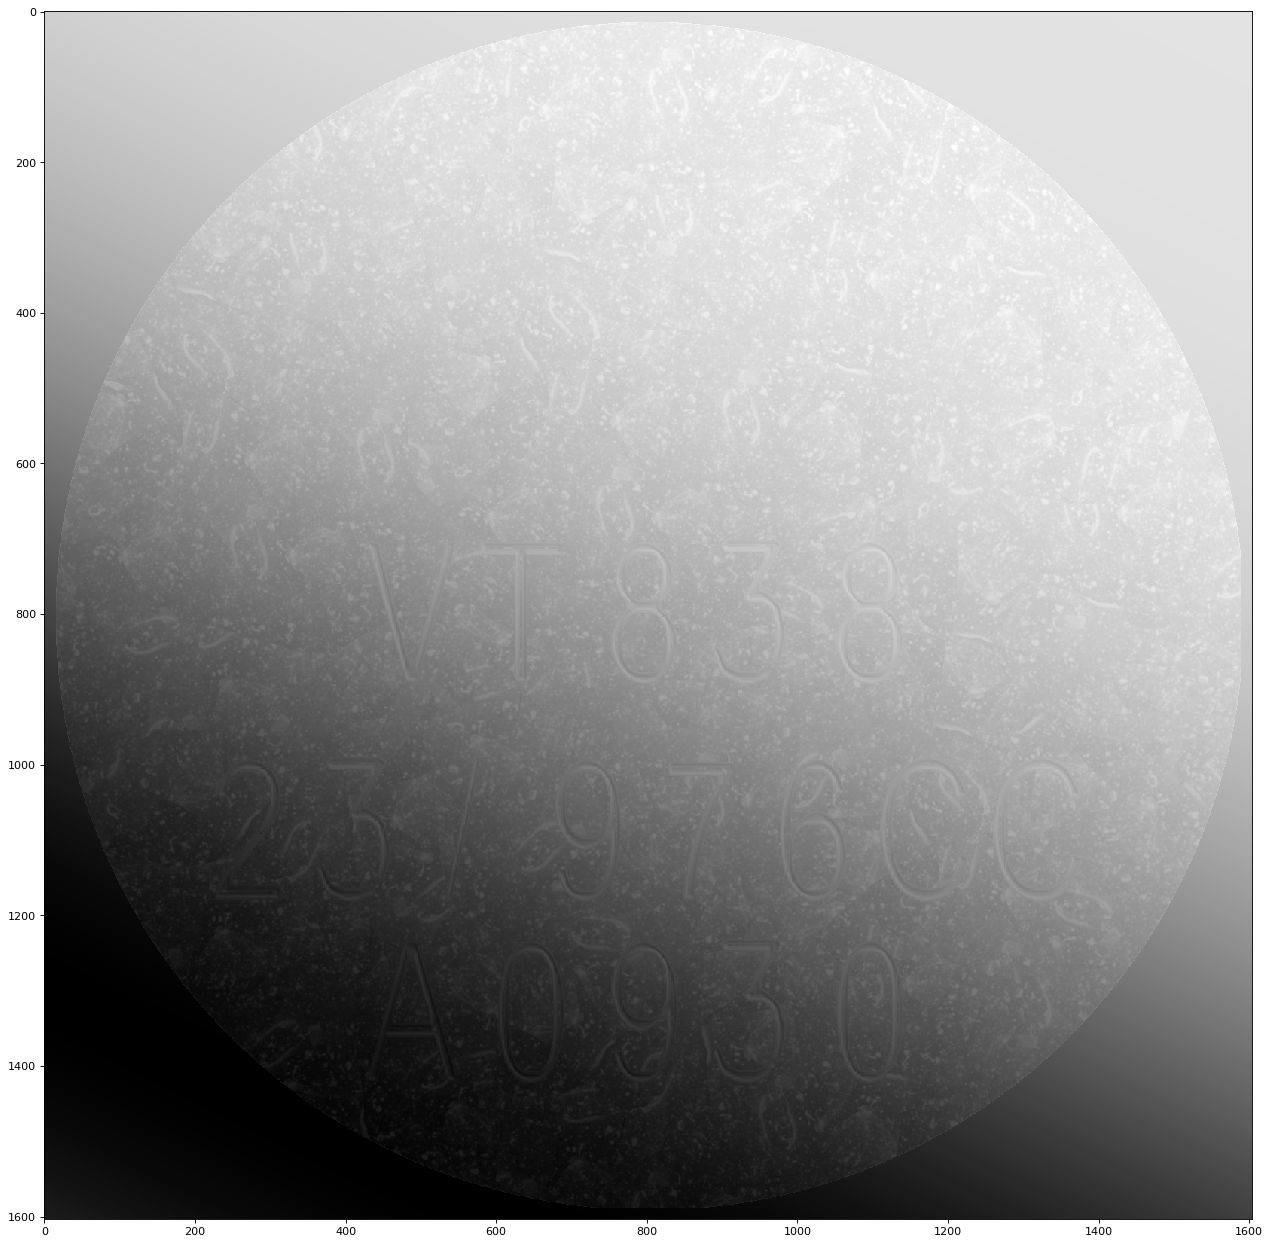

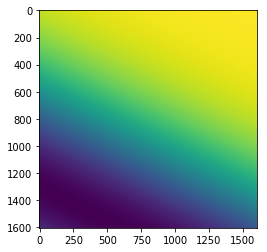

True

In [31]:
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
im_chip = './CHIP.png'

im_final, mask = add_parallel_light(im_chip)

plt.imshow(im_final)
plt.show()

plt.imshow(mask)
plt.show()

cv2.imwrite('./test_results.png', im_final)